In [1]:
!git clone https://github.com/AbrahamCamelo/ResearchMethods_GitHub.git

Cloning into 'ResearchMethods_GitHub'...
remote: Enumerating objects: 471, done.
remote: Counting objects: 100% (471/471), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 471 (delta 403), reused 448 (delta 394), pack-reused 0 (from 0)
Receiving objects: 100% (471/471), 2.10 MiB | 4.13 MiB/s, done.
Resolving deltas: 100% (403/403), done.


In [20]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer
import keras
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

In [3]:
df_average = pd.read_csv('ResearchMethods_GitHub/ndvi_data/average_ndvi.csv')
df_average['date'] = pd.to_datetime(df_average.date)
df_average = df_average.drop(columns=['Unnamed: 0'])

In [6]:
lst_ndvi = list(df_average.NDVI)

Goal: forecast the next 6 months (12 steps) from the last year (23 steps).

We are going to generate an array of x values that is going to a list of (lists of) predictors which are 23 steps (variables) in the time series and an array of y values that is going to have a list of (lists of) targets having the 12 steps following the 23 steps mentioned before.

In [43]:
n_past = 23
n_future = 1
n_total = n_past + n_future

last_index = len(lst_ndvi)
start_index = last_index - n_total

x_ndvi = []
y_ndvi = []

while start_index > 0:
  x_ndvi.append(lst_ndvi[start_index : start_index + n_past])
  y_ndvi.append(lst_ndvi[start_index + n_past : start_index + + n_total])
  start_index -= 1

x_ndvi = np.array(x_ndvi)
y_ndvi = np.array(y_ndvi).flatten()
print(x_ndvi.shape,y_ndvi.shape)
print(x_ndvi[0],y_ndvi[0],'\n',lst_ndvi[-n_total:])

(114, 23) (114,)
[0.24878722 0.25532555 0.27342907 0.25360088 0.32241667 0.33934254
 0.32739211 0.32080263 0.32741053 0.30295833 0.29243596 0.2873557
 0.32455263 0.44499386 0.4853307  0.35737281 0.32430921 0.27180439
 0.25947632 0.24794079 0.23704405 0.24128326 0.23409207] 0.2430762114537445 
 [0.2487872246696035, 0.2553255506607929, 0.2734290748898678, 0.2536008771929824, 0.3224166666666666, 0.3393425438596492, 0.3273921052631579, 0.3208026315789474, 0.3274105263157894, 0.3029583333333333, 0.2924359649122807, 0.2873557017543859, 0.3245526315789473, 0.4449938596491228, 0.4853307017543859, 0.3573728070175438, 0.3243092105263158, 0.2718043859649123, 0.2594763157894737, 0.2479407894736842, 0.2370440528634361, 0.2412832599118942, 0.2340920704845815, 0.2430762114537445]


Data must be in a 3D format (n_samples, n_timesteps, n_features). This reshape is necessary sometimes when using Keras.

It is like having a list of tables.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(x_ndvi, y_ndvi,
                                                    test_size=0.2, random_state=42)
# reshape data into the right format for RNNs
n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_steps = y_train.shape[0]
n_features = 1
X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features)
X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features)

print(X_train_rs.shape, X_test_rs.shape, y_train.shape, y_test.shape, n_samples, n_timesteps, n_features)

(90, 23, 1) (23, 23, 1) (90,) (23,) 90 23 1


In [59]:
random.seed(42)
batch_size = 32

simple_model = Sequential([
    InputLayer((n_timesteps,n_features)),
    LSTM(64, activation='tanh',input_shape=(n_timesteps, n_features)),
    Dense(y_train.shape[0]),
    ])
simple_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
simple_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.01),
loss='mean_squared_error',
metrics=[RootMeanSquaredError()],
)
smod_history = simple_model.fit(X_train_rs, y_train,
                                validation_split=0.2,
                                epochs=15,
                                batch_size=batch_size,
                                shuffle = True
                                )


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - loss: 0.0894 - root_mean_squared_error: 0.2954 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1103
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0137 - root_mean_squared_error: 0.1162 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0920
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0980
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0081 - root_mean_squared_error: 0.0899 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0903
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0072 - roo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
0.812177260646416


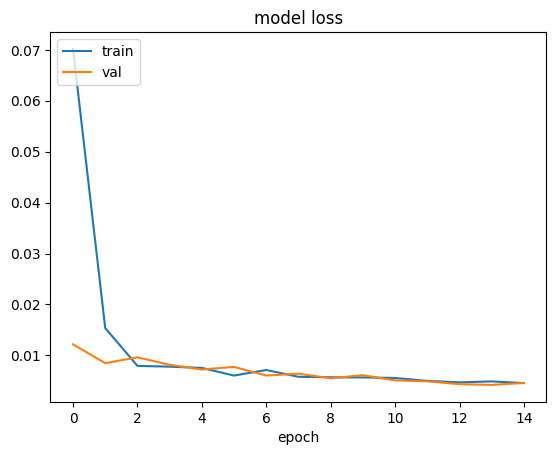

In [61]:
preds = simple_model.predict(X_test)
print(r2_score(preds, y_test))
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


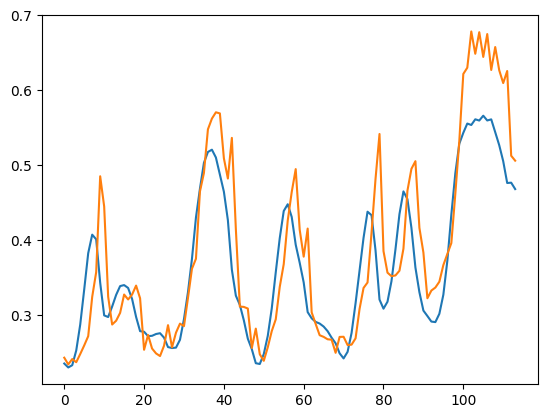

In [62]:
total_preds = simple_model.predict(x_ndvi)

plt.plot(total_preds)
plt.plot(y_ndvi)
plt.show()

In [ ]:
preds

array([[0.31791347, 0.3149133 , 0.3443817 , 0.36195835, 0.26998156,
        0.32763818, 0.32392198, 0.31833124, 0.43262732, 0.34681308,
        0.40857494, 0.25856465],
       [0.3522913 , 0.3399785 , 0.36289185, 0.37601164, 0.28457573,
        0.35209724, 0.33742929, 0.3399564 , 0.4450394 , 0.35906368,
        0.41941178, 0.27855563],
       [0.35206664, 0.34758988, 0.36586404, 0.3801828 , 0.28331152,
        0.3548606 , 0.33539176, 0.34589323, 0.4453122 , 0.3578353 ,
        0.41673505, 0.28224352],
       [0.31368724, 0.3205754 , 0.34443146, 0.36671507, 0.26629278,
        0.32792863, 0.318357  , 0.32109112, 0.43318927, 0.34374   ,
        0.40321067, 0.2588971 ],
       [0.34214276, 0.35609186, 0.36625147, 0.3977849 , 0.27734628,
        0.35322955, 0.32104418, 0.34317905, 0.44794446, 0.34992963,
        0.4037639 , 0.27317318],
       [0.3354545 , 0.33854252, 0.36025017, 0.3718856 , 0.27537426,
        0.34409264, 0.33102977, 0.33953875, 0.43549132, 0.3508147 ,
        0.41144097,